# Podcast Analysis (Need a new and better title)

## A bit about the process

This analysis is heavily influenced by the fact that I got stuck trying to figure out the categories table and how to extract information from this. A lot of podcasts was filed with more than one category. There was no time for either of the categories so I could not filter for the latest category of each podcast. You will see in the notebook some of the problems and how I tried to solve these. I've tried to extract the essentials here as I had to "abandon" the first analysis. So I could finish this in a reasonable time. I would have liked to do more statistical analysis here and I tried to find a way to do a "pretend A/B test" If i had the a date change for categories (assuming it has changed over time) and taking one Podcast and seeing if changing the category had an impact on review score or the content of the review if it brought in a different or new crowd. 
* Keep in mind that I have not worked out the exact way of how I would make this A/B test or if its doable at all since what I hoped I had access to was missing.



## Findings
* There are a lot of podcast categories and a lot of podcast have many subcategories. 
    * However most podcasts have a few subcategories: Between 1-3 subcategories.
    * The most reviewed podcasts have a few subcategories(based on total reviews)
        * This is not statistically tested, will come back to this in the future
* The most popular subcategories are society, culture, education, business, comedy and spirituality:
    * Society and Culture are the most popular subcategories.
        * Society and Culture are always part of the same category
* Podcasts have become increasingly more popular from 2005 ->  (Based on total reviews, listen time and total plays is not available in this dataset)
    * Podcasts saw a big increase during the pandemic years(2019-2021) and a dip in popularity after 2021
        * Podcasts reached peak popularity in 2020
* Podcasts where higher rated between 2012 and 2019 and lower rated between 2006 and 2012 and 2019 and 2023
    * podcast reviews for 2023 are only for the first two months. 
        * Doing a Z-test we found that podcasts where higher rated in 2022 compared to 2021. 
* Podcasts where higher rated on average during spring months (March, April and May) compared to the summer months (June, July and August).
    * A Z-test and confidence interval confirmed this.
        * Why is this ? Winter depression going away? More or fewer new podcasts releasing ? or some other unknown factors?


## Future improvements

* More statistical tests
    * Subcategory 1 vs Subcategory 2
        * Does either subcategory have a greater impact on review score ? 
* Whats the subcategories of the most popular podcasts, when did that podcast gain traction and are there more podcasts in the market after the popular podcast(s) got traction
* The one review per author was a mistake or it should have been handled in another way, hindsight is a menace sometimes, some eager fans have lost many reviews. However it does help that the same author only has one review when using total amount of reviews as a measure of how popular a podcast is. Without it being skewed because of eager fans. 
    * Future analysis, check wether or not removing all but one review per author makes some podcasts climb or fall on the top 10 most popular podcasts.
    * Check how eager fans impact review scores of a few podcasts and if the change (if there is any) has any statistical significance. 


Importing necessary libraries and setting the seaborn figure style to darkgrid

In [33]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from statsmodels.stats.weightstats import ztest as ztest
import scipy.stats as st
import statsmodels.stats.api as sms
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from math import ceil
from statistics import NormalDist

sns.set_style("darkgrid")

In [34]:
con = sqlite3.connect("database.sqlite")
cur = con.cursor()

In [35]:
%load_ext sql
conn = duckdb.connect()
%sql conn --alias duckdb
%config SqlMagic.autopandas = True

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


We have 110 024 different podcasts in this database

In [36]:
cur = con.cursor()
prompt = """
SELECT COUNT(p_id) AS count_of_podcasts
FROM(SELECT DISTINCT(podcast_id) AS p_id
FROM categories)
LIMIT 2
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,count_of_podcasts
0,110024


In [37]:
cur = con.cursor()
prompt = """SELECT p.title, COUNT(*) as count, c.category
            FROM reviews r
            JOIN podcasts p
            ON r.podcast_id = p.podcast_id
            JOIN categories c
            ON c.podcast_id = r.podcast_id
            GROUP BY r.podcast_id
            ORDER BY count DESC
            LIMIT 100"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df

,title,count,category
0,Crime Junkie,33104,true-crime
1,Wow in the World,29094,education
2,My Favorite Murder with Karen Kilgariff and Ge...,21350,comedy
3,Know Your Aura with Mystic Michaela,20236,education
4,Don't Keep Your Day Job,19728,business
...,...,...,...
95,Past Gas by Donut Media,3393,comedy
96,Philosophize This!,3375,education
97,Potterless,3369,arts
98,An Acquired Taste Podcast,3355,comedy


# One Review Per Author Per Podcast

Creating a dataframe where every review author has only one review per podcast, this is to remove multiple reviews from the same author on the same podcast and mitigating potential review bombing. 

Potential analysis for the future, look into podcasts with review bombs and see if the review bombing has a statistically significant impact on the mean review score of said podcasts. 

In [38]:
cur = con.cursor()
prompt = """
SELECT p.podcast_id, p.title AS podcast, r.author_id, r.title AS review_title, COUNT(r.title) AS one_review_per_author_per_podcast
FROM reviews r
JOIN podcasts p
ON r.podcast_id = p.podcast_id
GROUP BY podcast, r.author_id, review_title
HAVING one_review_per_author_per_podcast = 1
ORDER BY one_review_per_author_per_podcast DESC
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
df[0:2]

,podcast_id,podcast,author_id,review_title,one_review_per_author_per_podcast
0,a461252c09ccc5f142bd604ef9a40fcd,! Weird Rap Podcast !,189068CD52A9AA5,Keep it weird,1
1,a461252c09ccc5f142bd604ef9a40fcd,! Weird Rap Podcast !,199C3835F333D11,Biased review,1


In [39]:
%%sql
one_review_df <<
SELECT podcast_id, podcast, COUNT(review_title) AS num_of_reviews
FROM df
GROUP BY podcast, podcast_id
ORDER BY num_of_reviews DESC

Running query in 'duckdb'

In [40]:
one_review_df

,podcast_id,podcast,num_of_reviews
0,bf5bf76d5b6ffbf9a31bba4480383b7f,Crime Junkie,31052
1,bc5ddad3898e0973eb541577d1df8004,My Favorite Murder with Karen Kilgariff and Ge...,9727
2,f5fce0325ac6a4bf5e191d6608b95797,The Ben Shapiro Show,7464
3,b1a3eb2aa8e82ecbe9c91ed9a963c362,True Crime Obsessed,6677
4,bad6c91efdbee814db985c7a65199604,Wow in the World,5565
...,...,...,...
109989,fa3d0cc9b7b3010621c995da27c55315,Think For Yourself,1
109990,ffb5720165eef1ca97ca599c7da8d503,Think: Digital Futures,1
109991,d0baca131a9441d31a151a58c86b464e,ThinkRadio with Alan Wartes,1
109992,f5897d885d7c935d66caa6d8298504b7,ThinkTorah.org,1


Taking a second look into one of the "review bombers", it seems more likely that he is a passionate fan as the reviews are from different days and the content is different, initially based the first hypothesis on the title of the review being the same and overlooked some other factors, I would change this and maybe do some better filtering or not base the the analysis further down on only one review per author per podcast. 

A DISTINCT statement encapsulating podcast_id, author_id, title, content and rating would be a simple way of removing duplicated reviews or review bombings (I would not add created at in this DISTINCT statement as it is specific to the second, if I divided it into month, year and possibly date I would consider using time created without H:M:S)

In [41]:
cur = con.cursor()
prompt = """
SELECT *
FROM reviews
WHERE author_id = '791F376ACA3C08D' AND podcast_id = 'db93a05fe337aea2061b59c96e647100'
ORDER BY created_at
LIMIT 100
"""
cur.execute(prompt)
more_than_1_review = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
more_than_1_review

,podcast_id,title,content,rating,author_id,created_at
0,db93a05fe337aea2061b59c96e647100,Man...,I’m off the GRAM and now I cram grams.\n\n ...,5,791F376ACA3C08D,2019-08-26T21:23:18-07:00
1,db93a05fe337aea2061b59c96e647100,CONFIDENCE,Is vey sexy...don’t ya think? PALANCE. You sme...,5,791F376ACA3C08D,2019-09-26T08:36:36-07:00
2,db93a05fe337aea2061b59c96e647100,"Dear Joe,",I have a serious issue. I did some “rolling” l...,5,791F376ACA3C08D,2019-10-12T09:38:27-07:00
3,db93a05fe337aea2061b59c96e647100,"Dear Joe,",You were much more handsome on NEWSRADIO. I do...,5,791F376ACA3C08D,2019-10-19T16:14:58-07:00
4,db93a05fe337aea2061b59c96e647100,"Dear Joe,",Happy Halloween. You ought to pass out supplem...,5,791F376ACA3C08D,2019-10-26T15:34:47-07:00
...,...,...,...,...,...,...
61,db93a05fe337aea2061b59c96e647100,"Dear Joe,",Your steadfast dedication to working out makes...,1,791F376ACA3C08D,2020-09-13T20:36:40-07:00
62,db93a05fe337aea2061b59c96e647100,"Dear Joe,",To think some look at you as some modern day L...,1,791F376ACA3C08D,2020-09-24T18:57:56-07:00
63,db93a05fe337aea2061b59c96e647100,"Dear Joe,","Your bloody, dry, and chapped lips are grossin...",1,791F376ACA3C08D,2020-10-03T18:59:43-07:00
64,db93a05fe337aea2061b59c96e647100,"Dear Joe,",You and Maynard are complete TOOLS. 🕯\n\n ...,1,791F376ACA3C08D,2020-10-23T16:41:32-07:00


# Categories df

In [42]:
cur = con.cursor()
prompt = """
SELECT *
FROM categories
"""
cur.execute(prompt)
categories_df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()
categories_df

,podcast_id,category
0,c61aa81c9b929a66f0c1db6cbe5d8548,arts
1,c61aa81c9b929a66f0c1db6cbe5d8548,arts-performing-arts
2,c61aa81c9b929a66f0c1db6cbe5d8548,music
3,ad4f2bf69c72b8db75978423c25f379e,arts
4,ad4f2bf69c72b8db75978423c25f379e,arts-design
...,...,...
212367,da8331a8fbbba6fe1e2653f2fa86e168,news
212368,da8331a8fbbba6fe1e2653f2fa86e168,news-news-commentary
212369,da8331a8fbbba6fe1e2653f2fa86e168,science
212370,d41b3b7b2413fcf202d8bef1512554dc,islam


### On average 1.93 categories per podcast (Don't confuse this with sub-categories)

Eg. arts-performing-arts is one category

In [43]:
%%sql
WITH t1 AS(
SELECT SUM(category_count) AS count_podcast_category_combo
FROM (
SELECT podcast_id, COUNT(category) AS category_count
FROM categories_df
GROUP BY podcast_id)
),
t2 AS(
SELECT COUNT(podcast_id) AS count_podcasts
FROM one_review_df
)
SELECT t1.count_podcast_category_combo, count_podcasts, count_podcast_category_combo/count_podcasts AS average_category_per_podcast
FROM t1
CROSS JOIN t2

Running query in 'duckdb'

,count_podcast_category_combo,count_podcasts,average_category_per_podcast
0,212372.0,109994,1.93076


Adding all categories for each podcast into one, there will be duplicated sub categories

In [44]:
%%sql
duped_categories_df <<
SELECT podcast_id, STRING_AGG(category, '-') AS category
FROM categories_df
GROUP BY podcast_id

Running query in 'duckdb'

Split the one duped category into several columns which have one subcategory in it each

In [45]:
%%sql
split_dupe_df <<
SELECT
podcast_id,
SPLIT_PART(category, '-', 1) AS category1,
SPLIT_PART(category, '-', 2) AS category2,
SPLIT_PART(category, '-', 3) AS category3,
SPLIT_PART(category, '-', 4) AS category4,
SPLIT_PART(category, '-', 5) AS category5,
SPLIT_PART(category, '-', 6) AS category6,
SPLIT_PART(category, '-', 7) AS category7,
SPLIT_PART(category, '-', 8) AS category8,
SPLIT_PART(category, '-', 9) AS category9,
SPLIT_PART(category, '-', 10) AS category10,
SPLIT_PART(category, '-', 11) AS category11,
SPLIT_PART(category, '-', 12) AS category12,
SPLIT_PART(category, '-', 13) AS category13,
SPLIT_PART(category, '-', 14) AS category14,
SPLIT_PART(category, '-', 15) AS category15,
SPLIT_PART(category, '-', 16) AS category16,
SPLIT_PART(category, '-', 17) AS category17,
SPLIT_PART(category, '-', 18) AS category18,
SPLIT_PART(category, '-', 19) AS category19,
SPLIT_PART(category, '-', 20) AS category20,
FROM duped_categories_df
ORDER BY category20 DESC


Running query in 'duckdb'

If category have already appeared for the podcast leave it as an empty field

In [46]:
%%sql
removed_dupe_cat_df <<
SELECT podcast_id, category1 AS cat1,
CASE WHEN TRIM(category2) = category1 THEN '' ELSE category2 END AS cat2,

CASE WHEN TRIM(category3) = category1 OR TRIM(category3) = category2 THEN '' ELSE category3 END AS cat3,

CASE WHEN TRIM(category4) = category1 OR TRIM(category4) = category2 OR TRIM(category4) = category3 THEN '' ELSE category4 END AS cat4,

CASE WHEN TRIM(category5) = category1 OR TRIM(category5) = category2 OR TRIM(category5) = category3 OR TRIM(category5) = category4 THEN '' ELSE category5 END AS cat5,

CASE WHEN TRIM(category6) = category1 OR TRIM(category6) = category2 OR TRIM(category6) = category3 OR TRIM(category6) = category4 OR TRIM(category6) = category5 THEN '' ELSE category6 END AS cat6,

CASE WHEN TRIM(category7) = category1 OR TRIM(category7) = category2 OR TRIM(category7) = category3 OR TRIM(category7) = category4 OR TRIM(category7) = category5 OR TRIM(category7) = category6 THEN '' ELSE category7 END AS cat7,

CASE WHEN TRIM(category8) = category1 OR TRIM(category8) = category2 OR TRIM(category8) = category3 OR TRIM(category8) = category4 OR TRIM(category8) = category5 OR TRIM(category8) = category6 OR TRIM(category8) = category7 THEN '' ELSE category8 END AS cat8,

CASE WHEN TRIM(category9) = category1 OR TRIM(category9) = category2 OR TRIM(category9) = category3 OR TRIM(category9) = category4 OR TRIM(category9) = category5 OR TRIM(category9) = category6 OR TRIM(category9) = category7 OR TRIM(category9) = category8  THEN '' ELSE category9 END AS cat9,

CASE WHEN TRIM(category10) = category1 OR TRIM(category10) = category2 OR TRIM(category10) = category3 OR TRIM(category10) = category4 OR TRIM(category10) = category5 OR TRIM(category10) = category6 OR TRIM(category10) = category7 OR TRIM(category10) = category8  OR TRIM(category10) = category9 THEN '' ELSE category10 END AS cat10,

CASE WHEN TRIM(category11) = category1 OR TRIM(category11) = category2 OR TRIM(category11) = category3 OR TRIM(category11) = category4 OR TRIM(category11) = category5 OR TRIM(category11) = category6 OR TRIM(category11) = category7 OR TRIM(category11) = category8  OR TRIM(category11) = category9 OR TRIM(category11) = category10 THEN '' ELSE category11 END AS cat11,

CASE WHEN TRIM(category12) = category1 OR TRIM(category12) = category2 OR TRIM(category12) = category3 OR TRIM(category12) = category4 OR TRIM(category12) = category5 OR TRIM(category12) = category6 OR TRIM(category12) = category7 OR TRIM(category12) = category8  OR TRIM(category12) = category9 OR TRIM(category12) = category10 OR TRIM(category12) = category11 THEN '' ELSE category12 END AS cat12,

CASE WHEN TRIM(category13) = category1 OR TRIM(category13) = category2 OR TRIM(category13) = category3 OR TRIM(category13) = category4 OR TRIM(category13) = category5 OR TRIM(category13) = category6 OR TRIM(category13) = category7 OR TRIM(category13) = category8  OR TRIM(category13) = category9 OR TRIM(category13) = category10 OR TRIM(category13) = category11 OR TRIM(category13) = category12 THEN '' ELSE category13 END AS cat13,

CASE WHEN TRIM(category14) = category1 OR TRIM(category14) = category2 OR TRIM(category14) = category3 OR TRIM(category14) = category4 OR TRIM(category14) = category5 OR TRIM(category14) = category6 OR TRIM(category14) = category7 OR TRIM(category14) = category8  OR TRIM(category14) = category9 OR TRIM(category14) = category10 OR TRIM(category14) = category11 OR TRIM(category14) = category12 OR TRIM(category14) = category13 THEN '' ELSE category14 END AS cat14,

CASE WHEN TRIM(category15) = category1 OR TRIM(category15) = category2 OR TRIM(category15) = category3 OR TRIM(category15) = category4 OR TRIM(category15) = category5 OR TRIM(category15) = category6 OR TRIM(category15) = category7 OR TRIM(category15) = category8  OR TRIM(category15) = category9 OR TRIM(category15) = category10 OR TRIM(category15) = category11 OR TRIM(category15) = category12 OR TRIM(category15) = category13 OR TRIM(category15) = category14 THEN '' ELSE category15 END AS cat15,

CASE WHEN TRIM(category16) = category1 OR TRIM(category16) = category2 OR TRIM(category16) = category3 OR TRIM(category16) = category4 OR TRIM(category16) = category5 OR TRIM(category16) = category6 OR TRIM(category16) = category7 OR TRIM(category16) = category8  OR TRIM(category16) = category9 OR TRIM(category16) = category10 OR TRIM(category16) = category11 OR TRIM(category16) = category12 OR TRIM(category16) = category13 OR TRIM(category16) = category14 OR TRIM(category16) = category15 THEN '' ELSE category16 END AS cat16,

CASE WHEN TRIM(category17) = category1 OR TRIM(category17) = category2 OR TRIM(category17) = category3 OR TRIM(category17) = category4 OR TRIM(category17) = category5 OR TRIM(category17) = category6 OR TRIM(category17) = category7 OR TRIM(category17) = category8  OR TRIM(category17) = category9 OR TRIM(category17) = category10 OR TRIM(category17) = category11 OR TRIM(category17) = category12 OR TRIM(category17) = category13 OR TRIM(category17) = category14 OR TRIM(category17) = category15 OR TRIM(category17) = category16 THEN '' ELSE category17 END AS cat17,

CASE WHEN TRIM(category18) = category1 OR TRIM(category18) = category2 OR TRIM(category18) = category3 OR TRIM(category18) = category4 OR TRIM(category18) = category5 OR TRIM(category18) = category6 OR TRIM(category18) = category7 OR TRIM(category18) = category8  OR TRIM(category18) = category9 OR TRIM(category18) = category10 OR TRIM(category18) = category11 OR TRIM(category18) = category12 OR TRIM(category18) = category13 OR TRIM(category18) = category14 OR TRIM(category18) = category15 OR TRIM(category18) = category16 OR TRIM(category18) = category17 THEN '' ELSE category18 END AS cat18,

CASE WHEN TRIM(category19) = category1 OR TRIM(category19) = category2 OR TRIM(category19) = category3 OR TRIM(category19) = category4 OR TRIM(category19) = category5 OR TRIM(category19) = category6 OR TRIM(category19) = category7 OR TRIM(category19) = category8  OR TRIM(category19) = category9 OR TRIM(category19) = category10 OR TRIM(category19) = category11 OR TRIM(category19) = category12 OR TRIM(category19) = category13 OR TRIM(category19) = category14 OR TRIM(category19) = category15 OR TRIM(category19) = category16 OR TRIM(category19) = category17 OR TRIM(category19) = category18 THEN '' ELSE category19 END AS cat19,

CASE WHEN TRIM(category20) = category1 OR TRIM(category20) = category2 OR TRIM(category20) = category3 OR TRIM(category20) = category4 OR TRIM(category20) = category5 OR TRIM(category20) = category6 OR TRIM(category20) = category7 OR TRIM(category20) = category8  OR TRIM(category20) = category9 OR TRIM(category20) = category10 OR TRIM(category20) = category11 OR TRIM(category20) = category12 OR TRIM(category20) = category13 OR TRIM(category20) = category14 OR TRIM(category20) = category15 OR TRIM(category20) = category16 OR TRIM(category20) = category17 OR TRIM(category20) = category18 OR TRIM(category20) = category19 THEN '' ELSE category20 END AS cat20,
FROM split_dupe_df

Running query in 'duckdb'

In [47]:
removed_dupe_cat_df

,podcast_id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20
0,fa8c359031380cd4f3b38358c8a75f92,business,,careers,education,,self,improvement,society,culture,...,,personal,journals,,,philosophy,,,places,travel
1,fbd39776094ee5e641ecaf1ff971c388,health,fitness,,,,,,,,...,,,,,,,,,,
2,d277dc926e46ff187defb6828c6bf961,spirituality,,,,,,,,,...,,,,,,,,,,
3,a68a77d4295d482d0ddba9e857cc1234,education,,,,,,,,,...,,,,,,,,,,
4,b221de67cf9ca5ca418b1f0c1e78dc9d,education,,,,,,,,,...,,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110019,fbc7c1c216bea70d42f40ea6ff57ec25,society,culture,,,documentary,,,personal,journals,...,,,,,,,,,,
110020,fbccd2dfefdcd6bf61e21da3bb735c8f,sports,,,,,,,,,...,,,,,,,,,,
110021,e13c8b732ccf065b819c372d8e117408,comedy,,,,,,,,,...,,,,,,,,,,
110022,e13ff9e8e236ec15c651860c372ba293,arts,,,,,,,,,...,,,,,,,,,,


Turning all empty fields into Null values

In [48]:
%%sql
combined_removed_dupe_df <<
SELECT podcast_id, 
CASE WHEN TRIM(cat1) = '' THEN NULL ELSE cat1 END as category1,
CASE WHEN TRIM(cat2) = '' THEN NULL ELSE cat2 END as category2,
CASE WHEN TRIM(cat3) = '' THEN NULL ELSE cat3 END as category3,
CASE WHEN TRIM(cat4) = '' THEN NULL ELSE cat4 END as category4,
CASE WHEN TRIM(cat5) = '' THEN NULL ELSE cat5 END as category5,
CASE WHEN TRIM(cat6) = '' THEN NULL ELSE cat6 END as category6,
CASE WHEN TRIM(cat7) = '' THEN NULL ELSE cat7 END as category7,
CASE WHEN TRIM(cat8) = '' THEN NULL ELSE cat8 END as category8,
CASE WHEN TRIM(cat9) = '' THEN NULL ELSE cat9 END as category9,
CASE WHEN TRIM(cat10) = '' THEN NULL ELSE cat10 END as category10,
CASE WHEN TRIM(cat11) = '' THEN NULL ELSE cat11 END as category11,
CASE WHEN TRIM(cat12) = '' THEN NULL ELSE cat12 END as category12,
CASE WHEN TRIM(cat13) = '' THEN NULL ELSE cat13 END as category13,
CASE WHEN TRIM(cat14) = '' THEN NULL ELSE cat14 END as category14,
CASE WHEN TRIM(cat15) = '' THEN NULL ELSE cat15 END as category15,
CASE WHEN TRIM(cat16) = '' THEN NULL ELSE cat16 END as category16,
CASE WHEN TRIM(cat17) = '' THEN NULL ELSE cat16 END as category17,
CASE WHEN TRIM(cat18) = '' THEN NULL ELSE cat16 END as category18,
CASE WHEN TRIM(cat19) = '' THEN NULL ELSE cat16 END as category19,
CASE WHEN TRIM(cat20) = '' THEN NULL ELSE cat16 END as category20,
FROM removed_dupe_cat_df

Running query in 'duckdb'

In [49]:
combined_removed_dupe_df

,podcast_id,category1,category2,category3,category4,category5,category6,category7,category8,category9,...,category11,category12,category13,category14,category15,category16,category17,category18,category19,category20
0,fa8c359031380cd4f3b38358c8a75f92,business,None,careers,education,None,self,improvement,society,culture,...,None,personal,journals,None,None,philosophy,None,None,philosophy,philosophy
1,fbd39776094ee5e641ecaf1ff971c388,health,fitness,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,d277dc926e46ff187defb6828c6bf961,spirituality,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,a68a77d4295d482d0ddba9e857cc1234,education,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,b221de67cf9ca5ca418b1f0c1e78dc9d,education,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110019,fbc7c1c216bea70d42f40ea6ff57ec25,society,culture,None,None,documentary,None,None,personal,journals,...,None,None,None,None,None,None,None,None,None,None
110020,fbccd2dfefdcd6bf61e21da3bb735c8f,sports,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
110021,e13c8b732ccf065b819c372d8e117408,comedy,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
110022,e13ff9e8e236ec15c651860c372ba293,arts,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


Turning the subcategories into one category for each podcast and calculating the string length of the "mega" category. 

We do this because we have ended up making alot of categories that are the same but will be countet differently, such as:

Arts-science
and
Science-Arts 

Which will be counted as different podcasts but are in my opinion the same, based on what we have done with this data set


In [50]:
%%sql
rabbit_hole_df <<
SELECT podcast_id, the_one_category, LENGTH(the_one_category) as len_category
FROM (SELECT podcast_id, CONCAT_WS('-',category1,category2,category3,category4,category5,category6,
                 category7,category8,category9,category10,
                 category11,category12,category13,category14,
                 category15,category16,category17,
                 category18,category19,category20) AS the_one_category
FROM combined_removed_dupe_df)
GROUP BY the_one_category, podcast_id

Running query in 'duckdb'

In [51]:
%%sql
visualizing_the_rabbit_hole << 
SELECT len_category, COUNT(podcast_id) AS count
FROM rabbit_hole_df
GROUP BY len_category
ORDER BY len_category

Running query in 'duckdb'

I had a bigger plan for this initially, however I kept on meeting new problems when trying to deal with the multiple categories for many of the podcasts, The initial plan was to find which subcategories are most popular (based on reviews) and which are most common (based on podcasts with that subcategory). I hope to come back to this, but due to the deadline and other time constraints right now I have to leave it as is (for now).

<Figure size 1200x800 with 0 Axes>

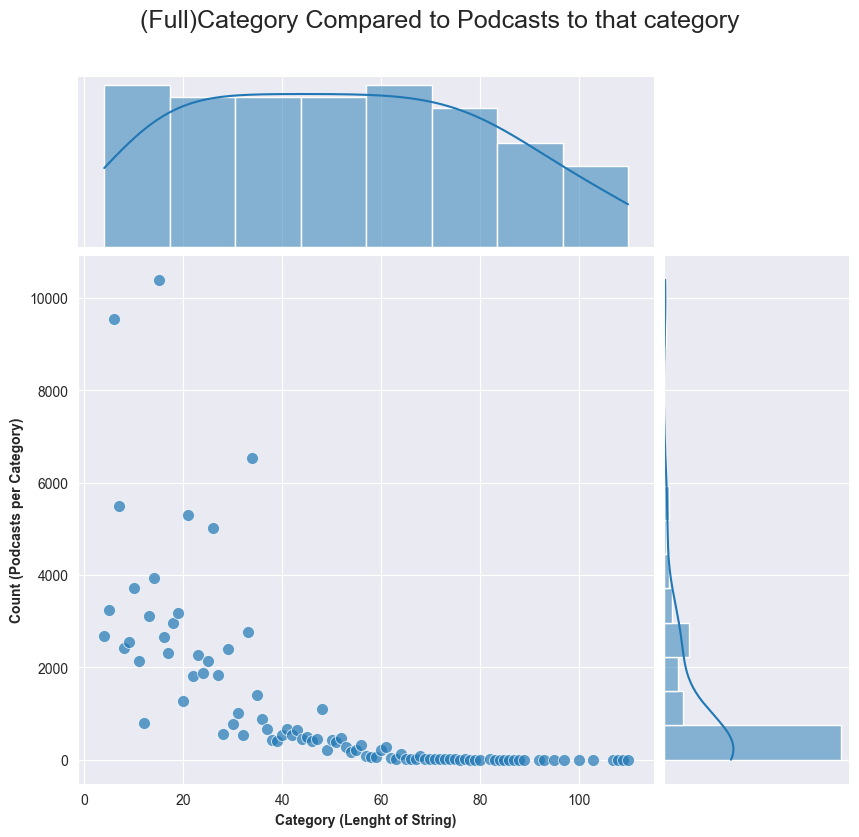

In [52]:
plt.figure(figsize=(12, 8))
g = sns.JointGrid(
    data=visualizing_the_rabbit_hole,
    x="len_category",
    y="count",
    height=8.5,
    ratio=3,
    space=0.05,
)
g.ax_joint.set_xlabel("Category (Length of string)", fontweight="bold")
g.ax_joint.set_ylabel("Podcasts Per Category", fontweight="bold")
g.plot_joint(sns.scatterplot, s=75, alpha=0.7)
g.plot_marginals(sns.histplot, kde=True)

g.fig.suptitle("(Full)Category Compared to Podcasts to that category", fontsize=18)
g.fig.subplots_adjust(top=0.90)
g.set_axis_labels(xlabel="Category (Lenght of String)", ylabel="Count (Podcasts per Category)")
plt.show();

## Sub category count

We take the removed_dupe_cat_df and instead of using it to make one lone category we keep it split and turn the empty fields into 0 and all others into one, to count the amount of subcategories for each podcast. 

In [53]:
%%sql
rabbit_hole_1_and_0_df <<
SELECT podcast_id, 
CASE WHEN TRIM(cat1) = '' THEN 0 ELSE 1 END as category1,
CASE WHEN TRIM(cat2) = '' THEN 0 ELSE 1 END as category2,
CASE WHEN TRIM(cat3) = '' THEN 0 ELSE 1 END as category3,
CASE WHEN TRIM(cat4) = '' THEN 0 ELSE 1 END as category4,
CASE WHEN TRIM(cat5) = '' THEN 0 ELSE 1 END as category5,
CASE WHEN TRIM(cat6) = '' THEN 0 ELSE 1 END as category6,
CASE WHEN TRIM(cat7) = '' THEN 0 ELSE 1 END as category7,
CASE WHEN TRIM(cat8) = '' THEN 0 ELSE 1 END as category8,
CASE WHEN TRIM(cat9) = '' THEN 0 ELSE 1 END as category9,
CASE WHEN TRIM(cat10) = '' THEN 0 ELSE 1 END as category10,
CASE WHEN TRIM(cat11) = '' THEN 0 ELSE 1 END as category11,
CASE WHEN TRIM(cat12) = '' THEN 0 ELSE 1 END as category12,
CASE WHEN TRIM(cat13) = '' THEN 0 ELSE 1 END as category13,
CASE WHEN TRIM(cat14) = '' THEN 0 ELSE 1 END as category14,
CASE WHEN TRIM(cat15) = '' THEN 0 ELSE 1 END as category15,
CASE WHEN TRIM(cat16) = '' THEN 0 ELSE 1 END as category16,
CASE WHEN TRIM(cat17) = '' THEN 0 ELSE 1 END as category17,
CASE WHEN TRIM(cat18) = '' THEN 0 ELSE 1 END as category18,
CASE WHEN TRIM(cat19) = '' THEN 0 ELSE 1 END as category19,
CASE WHEN TRIM(cat20) = '' THEN 0 ELSE 1 END as category20,
FROM removed_dupe_cat_df

Running query in 'duckdb'

we make a total count subcategories for each podcast

In [54]:
%%sql
sub_category_count_df <<
SELECT podcast_id, category1 + category2 + category3 + category4 + 
category5 + category6 + category7 + category8 + category9 + 
category10 + category11 + category12 + category13 + 
category14 + category15 + category16 + category17 + 
category18 + category19 + category20 AS nr_of_subcategories
FROM rabbit_hole_1_and_0_df
ORDER BY nr_of_subcategories DESC

Running query in 'duckdb'

We combine subcategory count with review count

In [55]:
%%sql
sub_categories_podcast_reviews_df <<
WITH t1 AS(
    SELECT nr_of_subcategories, COUNT(podcast_id) AS nr_of_podcasts_with_subcategories
    FROM sub_category_count_df
    GROUP BY nr_of_subcategories
)
SELECT r.podcast,r.num_of_reviews, t1.nr_of_subcategories, t1.nr_of_podcasts_with_subcategories, 
FROM t1
JOIN sub_category_count_df scc
ON t1.nr_of_subcategories = scc.nr_of_subcategories
JOIN one_review_df r
ON scc.podcast_id = r.podcast_id 

Running query in 'duckdb'

In [56]:
sub_categories_podcast_reviews_df

,podcast,num_of_reviews,nr_of_subcategories,nr_of_podcasts_with_subcategories
0,Crime Junkie,31052,2,34550
1,My Favorite Murder with Karen Kilgariff and Ge...,9727,3,29210
2,The Ben Shapiro Show,7464,1,24033
3,True Crime Obsessed,6677,4,11180
4,Wow in the World,5565,5,6292
...,...,...,...,...
109989,P3: Prayer - Passion - Purpose,1,3,29210
109990,PA Talks,1,2,34550
109991,PAC Talks with VJCV,1,1,24033
109992,PALEMICA THE PODCAST,1,1,24033


In [57]:
%%sql
sub_cat_tot_podcast <<
SELECT DISTINCT nr_of_subcategories AS subcategories, nr_of_podcasts_with_subcategories AS podcasts
FROM sub_categories_podcast_reviews_df

Running query in 'duckdb'

In [58]:
%%sql
visualizing_sub_cat_review <<
WITH t1 AS(
SELECT nr_of_subcategories AS subcategories, SUM(num_of_reviews) AS tot_reviews, MAX(num_of_reviews) AS max_reviews_pp, MIN(num_of_reviews) AS min_reviews_pp
FROM sub_categories_podcast_reviews_df
GROUP BY subcategories),
t2 AS(
SELECT nr_of_subcategories AS subcategories, COUNT(*) AS podcasts
FROM sub_categories_podcast_reviews_df
GROUP BY subcategories
)
SELECT t1.subcategories, t2.podcasts, t1.tot_reviews, t1.tot_reviews/t2.podcasts AS avg_nr_of_review_per_podcast, t1.max_reviews_pp, t1.min_reviews_pp,
FROM t1
JOIN t2
ON t1.subcategories = t2.subcategories

Running query in 'duckdb'

In [59]:
visualizing_sub_cat_review[0:3]

,subcategories,podcasts,tot_reviews,avg_nr_of_review_per_podcast,max_reviews_pp,min_reviews_pp
0,2,34541,583391.0,16.889812,31052,1
1,10,23,1205.0,52.391304,604,2
2,7,802,38692.0,48.244389,4049,1


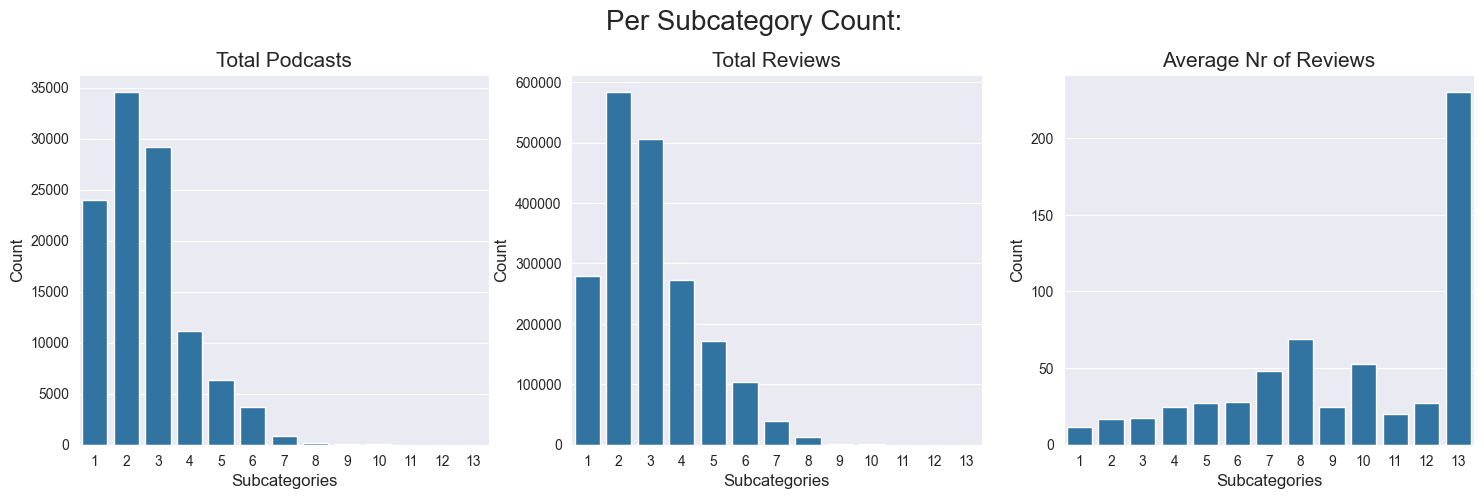

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [60]:
fig, axes = plt.subplots(1, 3, sharey="none")
fig.subplots_adjust(top=0.85)
sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="podcasts",
    ax=axes[0],
)
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="tot_reviews",
    ax=axes[1],
)
plt.figure(figsize=(12, 8))
g = sns.barplot(
    data=visualizing_sub_cat_review,
    x="subcategories",
    y="avg_nr_of_review_per_podcast",
    ax=axes[2],
)

# sns.set_context("paper", font_scale=1.3)
fig.set_figheight(5)
fig.set_figwidth(18)

fig.suptitle("Per Subcategory Count:", fontsize=20)
axes[0].set_title("Total Podcasts", fontsize=15)
axes[1].set_title("Total Reviews", fontsize=15)
axes[2].set_title("Average Nr of Reviews", fontsize=15)
axes[0].set_xlabel("Subcategories", fontsize=12)
axes[1].set_xlabel("Subcategories", fontsize=12)
axes[2].set_xlabel("Subcategories", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)
axes[2].set_ylabel("Count", fontsize=12)
plt.show();

# Most popular subcategories (Based on the amount of podcasts with said subcategory)

In [61]:
rabbit_hole_df

,podcast_id,the_one_category,len_category
0,bbf7d3552663f2544755aca9ceff5979,science-social-sciences,23
1,bc0b13bfbb61b89431a065bb3737516a,business-entrepreneurship-marketing,35
2,bc13e20436a1d6972ad4de3c8f2dac65,society-culture-documentary,27
3,bc200431cac25e1396b84de01de8e8e7,religion-spirituality-tv-film,29
4,bc92d853226792def92084f98b0cbe33,tv-film-history-interviews,26
...,...,...,...
110019,bb9de9571b19ff899bcf764de9346e88,health-fitness-mental-nutrition,31
110020,bbacc8479b65ce0ac2facd9d87cae93f,society-culture,15
110021,bbb452e75824a58a70a9ddc9fb1cac6a,society-culture,15
110022,bbb53c4b55dd74c2484112436e7c8a3a,leisure-video-games,19


Using the same dataframe, "rabbit_hole_df" we change all empty columns into Null values and all else as is

In [62]:
%%sql
split_df <<
SELECT podcast_id,
CASE WHEN TRIM(category1) = '' THEN NULL ELSE category1 END as category1,
CASE WHEN TRIM(category2) = '' THEN NULL ELSE category2 END as category2,
CASE WHEN TRIM(category3) = '' THEN NULL ELSE category3 END as category3,
CASE WHEN TRIM(category4) = '' THEN NULL ELSE category4 END as category4,
CASE WHEN TRIM(category5) = '' THEN NULL ELSE category5 END as category5,
CASE WHEN TRIM(category6) = '' THEN NULL ELSE category6 END as category6,
CASE WHEN TRIM(category7) = '' THEN NULL ELSE category7 END as category7,
CASE WHEN TRIM(category8) = '' THEN NULL ELSE category8 END as category8,
CASE WHEN TRIM(category9) = '' THEN NULL ELSE category9 END as category9,
CASE WHEN TRIM(category10) = '' THEN NULL ELSE category10 END as category10,
CASE WHEN TRIM(category11) = '' THEN NULL ELSE category11 END as category11,
CASE WHEN TRIM(category12) = '' THEN NULL ELSE category12 END as category12,
CASE WHEN TRIM(category13) = '' THEN NULL ELSE category13 END as category13,
FROM(SELECT podcast_id,
SPLIT_PART(the_one_category, '-', 1) AS category1,
SPLIT_PART(the_one_category, '-', 2) AS category2,
SPLIT_PART(the_one_category, '-', 3) AS category3,
SPLIT_PART(the_one_category, '-', 4) AS category4,
SPLIT_PART(the_one_category, '-', 5) AS category5,
SPLIT_PART(the_one_category, '-', 6) AS category6,
SPLIT_PART(the_one_category, '-', 7) AS category7,
SPLIT_PART(the_one_category, '-', 8) AS category8,
SPLIT_PART(the_one_category, '-', 9) AS category9,
SPLIT_PART(the_one_category, '-', 10) AS category10,
SPLIT_PART(the_one_category, '-', 11) AS category11,
SPLIT_PART(the_one_category, '-', 12) AS category12,
SPLIT_PART(the_one_category, '-', 13) AS category13,
FROM rabbit_hole_df)

Running query in 'duckdb'

In [63]:
split_df[0:2]

,podcast_id,category1,category2,category3,category4,category5,category6,category7,category8,category9,category10,category11,category12,category13
0,bbf7d3552663f2544755aca9ceff5979,science,social,sciences,None,None,None,None,None,None,None,None,None,None
1,bc0b13bfbb61b89431a065bb3737516a,business,entrepreneurship,marketing,None,None,None,None,None,None,None,None,None,None


In [64]:
%%sql 
SELECT COUNT(podcast_id) as count12, category12
    FROM split_df
    GROUP BY category12

Running query in 'duckdb'

,count12,category12
0,1,philosophy
1,1,religion
2,1,journals
3,110021,None


We first create a column called category with all out subcategories in it using UNION, 
We then count all the podcasts with that subcategory, we do this column by column (hence t1-t13). 
At the end we take the count for each subcategory from each column and combine them into one count for each subcategory

In [65]:
%%sql
sub_categories_count_df <<
WITH table_ultimate AS(
WITH t AS(
    SELECT category1 AS category
    FROM split_df
    UNION
    SELECT category2
    FROM split_df
    UNION
    SELECT category3
    FROM split_df
    UNION
    SELECT category4
    FROM split_df
    UNION
    SELECT category5
    FROM split_df
    UNION
    SELECT category6
    FROM split_df
    UNION
    SELECT category7
    FROM split_df
    UNION
    SELECT category8
    FROM split_df
    UNION
    SELECT category9
    FROM split_df
    UNION
    SELECT category10
    FROM split_df
    UNION
    SELECT category11
    FROM split_df
    UNION
    SELECT category12
    FROM split_df
    UNION
    SELECT category13
    FROM split_df
),
t1 AS(
    SELECT COUNT(podcast_id) as count1, category1
    FROM split_df
    GROUP BY category1
),
t2 AS(
    SELECT COUNT(podcast_id) as count2, category2
    FROM split_df
    GROUP BY category2
),
t3 AS(
    SELECT COUNT(podcast_id) as count3, category3
    FROM split_df
    GROUP BY category3
),
t4 AS(
    SELECT COUNT(podcast_id) as count4, category4
    FROM split_df
    GROUP BY category4
),
t5 AS(
    SELECT COUNT(podcast_id) as count5, category5
    FROM split_df
    GROUP BY category5
),
t6 AS(
    SELECT COUNT(podcast_id) as count6, category6
    FROM split_df
    GROUP BY category6
),
t7 AS(
    SELECT COUNT(podcast_id) as count7, category7
    FROM split_df
    GROUP BY category7
),
t8 AS(
    SELECT COUNT(podcast_id) as count8, category8
    FROM split_df
    GROUP BY category8
),
t9 AS(
    SELECT COUNT(podcast_id) as count9, category9
    FROM split_df
    GROUP BY category9
),
t10 AS(
    SELECT COUNT(podcast_id) as count10, category10
    FROM split_df
    GROUP BY category10
),
t11 AS(
    SELECT COUNT(podcast_id) as count11, category11
    FROM split_df
    GROUP BY category11
),
t12 AS(
    SELECT COUNT(podcast_id) as count12, category12
    FROM split_df
    GROUP BY category12
),
t13 AS(
    SELECT COUNT(podcast_id) as count13, category13
    FROM split_df
    GROUP BY category13
)
SELECT t.category, t1.count1, t2.count2, t3.count3, t4.count4, t5.count5, t6.count6, t7.count7, t8.count8, t9.count9, t10.count10, t11.count11, t12.count12, t13.count13
FROM t
LEFT JOIN t1
ON t.category = t1.category1
LEFT JOIN t2
ON t.category = t2.category2
LEFT JOIN t3
ON t.category = t3.category3
LEFT JOIN t4
ON t.category = t4.category4
LEFT JOIN t5
ON t.category = t5.category5
LEFT JOIN t6
ON t.category = t6.category6
LEFT JOIN t7
ON t.category = t7.category7
LEFT JOIN t8
ON t.category = t8.category8
LEFT JOIN t9
ON t.category = t9.category9
LEFT JOIN t10
ON t.category = t10.category10
LEFT JOIN t11
ON t.category = t11.category11
LEFT JOIN t12
ON t.category = t12.category12
LEFT JOIN t13
ON t.category = t13.category13)

SELECT category, IFNULL(count1, 0) + IFNULL(count2, 0) + IFNULL(count3, 0) + IFNULL(count4, 0) + IFNULL(count5, 0) + IFNULL(count6, 0)+ IFNULL(count7, 0) + IFNULL(count8, 0) + IFNULL(count9, 0) + IFNULL(count10, 0) + IFNULL(count11, 0) + IFNULL(count12, 0) + IFNULL(count13, 0) AS total_count
FROM table_ultimate
ORDER BY total_count DESC

Running query in 'duckdb'

## top 25 sub categories

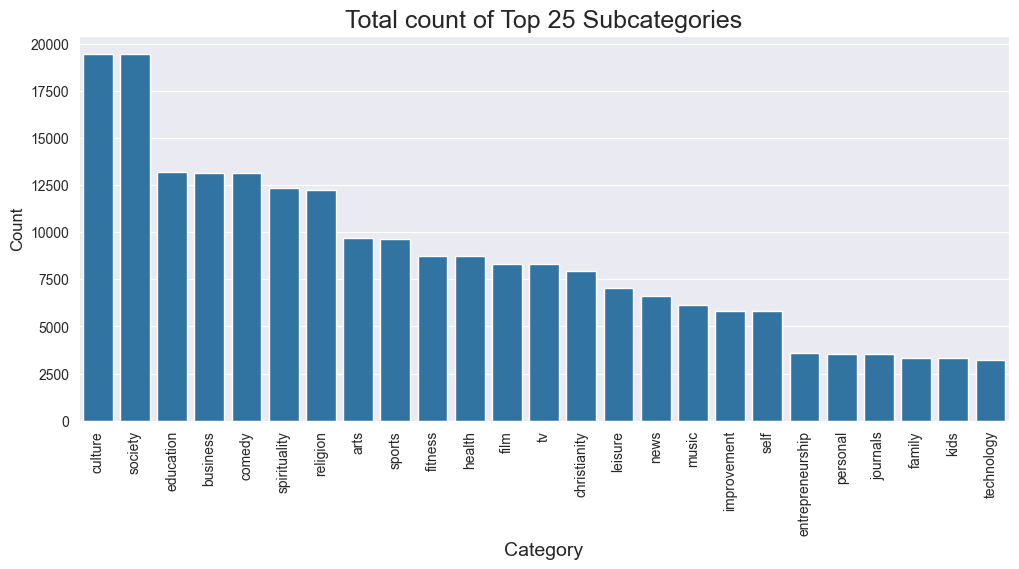

In [66]:
plt.figure(figsize=(12, 5))
g = sns.barplot(sub_categories_count_df[0:25], y="total_count", x="category")
plt.xticks(rotation=90)
g.set_title("Total count of Top 25 Subcategories", fontsize=18)
g.set_xlabel("Category", fontsize=14)
g.set_ylabel("Count", fontsize=12)
plt.show();

This plot shows the difference in total number for all categories, X-labels are removed as they will be too stacked and unreadable, see the plot for what it is, a visual representation of podcasts with x- or y-subcategory, visualizing that some subcategories are abundant while some are more scarce

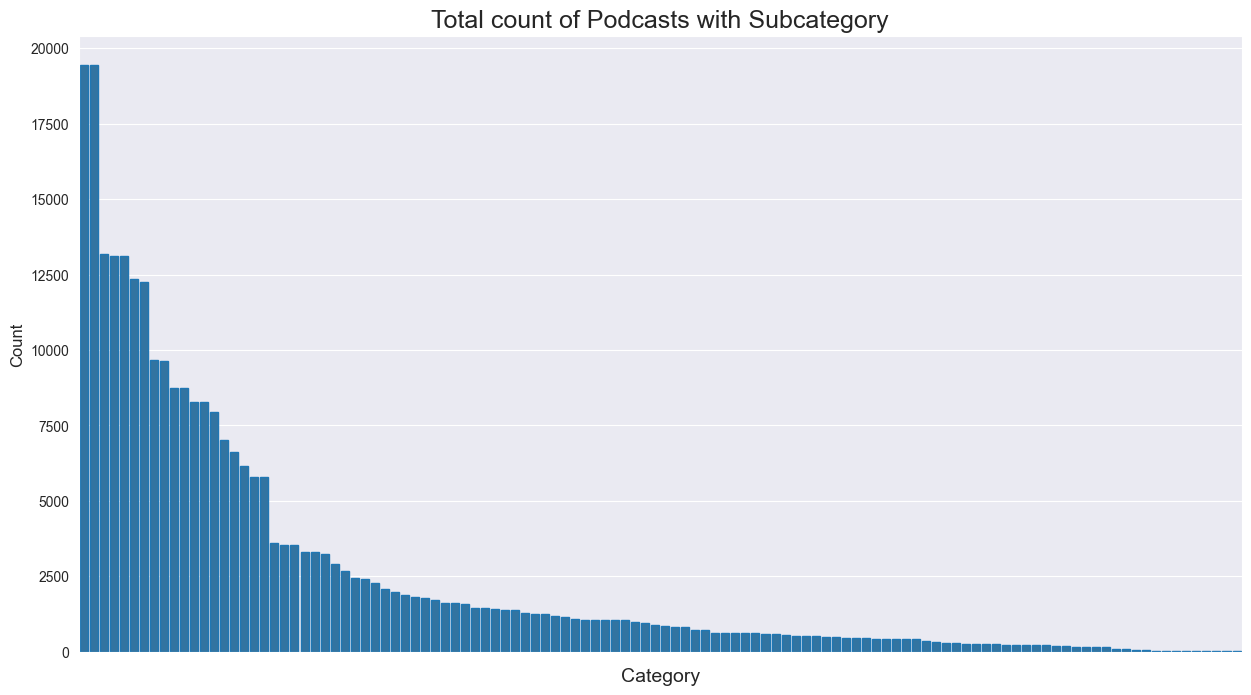

In [67]:
plt.figure(figsize=(15, 8))
g = sns.barplot(sub_categories_count_df, x="category", y="total_count", edgecolor="C0")
plt.xticks(rotation=90)
g.set_title("Total count of Podcasts with Subcategory", fontsize=18)
g.set_xlabel("Category", fontsize=14)
g.set_ylabel("Count", fontsize=12)
g.set(xticklabels=[])
plt.show();

## Reviews, subcategory 1 vs subcategory 2

In [68]:
one_review_df

,podcast_id,podcast,num_of_reviews
0,bf5bf76d5b6ffbf9a31bba4480383b7f,Crime Junkie,31052
1,bc5ddad3898e0973eb541577d1df8004,My Favorite Murder with Karen Kilgariff and Ge...,9727
2,f5fce0325ac6a4bf5e191d6608b95797,The Ben Shapiro Show,7464
3,b1a3eb2aa8e82ecbe9c91ed9a963c362,True Crime Obsessed,6677
4,bad6c91efdbee814db985c7a65199604,Wow in the World,5565
...,...,...,...
109989,fa3d0cc9b7b3010621c995da27c55315,Think For Yourself,1
109990,ffb5720165eef1ca97ca599c7da8d503,Think: Digital Futures,1
109991,d0baca131a9441d31a151a58c86b464e,ThinkRadio with Alan Wartes,1
109992,f5897d885d7c935d66caa6d8298504b7,ThinkTorah.org,1


In [69]:
cur = con.cursor()
prompt = """
SELECT r.podcast_id, p.title AS podcast, r.title AS review_title, r.content, r.rating, r.author_id
FROM reviews r
JOIN podcasts p
ON
r.podcast_id = p.podcast_id
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

In [70]:
%%sql 
review_rating_category_df <<
WITH t1 AS(SELECT DISTINCT podcast_id, podcast, review_title, rating, author_id
FROM df)
SELECT t1.podcast, t1.review_title, t1.rating, c.category1, c.category2, t1.author_id
FROM t1
JOIN split_df c
ON t1.podcast_id = c.podcast_id

Running query in 'duckdb'

In [71]:
%%sql
SELECT category1, AVG(rating) AS average_rating_c1, COUNT(rating) AS count_c1
FROM review_rating_category_df
GROUP BY category1
ORDER BY average_rating_c1 DESC

Running query in 'duckdb'

,category1,average_rating_c1,count_c1
0,hinduism,4.926966,178
1,spirituality,4.900952,2100
2,business,4.846527,216162
3,christianity,4.818906,81941
4,islam,4.816489,1504
5,health,4.813259,122030
6,religion,4.812841,25855
7,education,4.808751,146992
8,music,4.772562,42926
9,buddhism,4.771822,1306


In [72]:
%%sql
SELECT category2, AVG(rating) AS average_rating_c2, COUNT(rating) AS count_c2
FROM review_rating_category_df
GROUP BY category2
ORDER BY average_rating_c2 DESC

Running query in 'duckdb'

,category2,average_rating_c2,count_c2
0,rugby,4.984962,133
1,marketing,4.938465,11782
2,entrepreneurship,4.908710,64235
3,islam,4.903846,52
4,christianity,4.896319,1331
...,...,...,...
81,social,4.244732,7024
82,crime,4.225084,71840
83,politics,4.145476,26513
84,true,4.090992,27288


In [73]:
%%sql
average_rating_df <<
WITH t1 AS(SELECT category1, category2, AVG(rating) AS average_rating_category, COUNT(rating) AS count
FROM review_rating_category_df
GROUP BY category1, category2
HAVING count > 10
ORDER BY average_rating_category DESC),
t2 AS(
SELECT category1, AVG(rating) AS average_rating_c1, COUNT(rating) AS count_c1
FROM review_rating_category_df
GROUP BY category1
HAVING count_c1 > 10
ORDER BY average_rating_c1 DESC      
),
t3 AS(
SELECT category2, AVG(rating) AS average_rating_c2, COUNT(rating) AS count_c2
FROM review_rating_category_df
GROUP BY category2
HAVING count_c2 > 10
ORDER BY average_rating_c2 DESC
)
SELECT t1.category1, t1.category2, t1.average_rating_category, t2.average_rating_c1, t3.average_rating_c2, t1.count, t2.count_c1, t3.count_c2
FROM t1
JOIN t2
ON t1.category1 = t2.category1
JOIN t3
ON t1.category2 = t3.category2

Running query in 'duckdb'

Statistical question, does category 2 have an greater impact on overall rating than category1 ? 

In [74]:
%%sql
SELECT MIN(average_rating_category), MAX(average_rating_category), AVG(average_rating_category), MIN(average_rating_c1), MAX(average_rating_c1), AVG(average_rating_c1),
MIN(average_rating_c2), MAX(average_rating_c2), AVG(average_rating_c2)
FROM average_rating_df

Running query in 'duckdb'

,min(average_rating_category),max(average_rating_category),avg(average_rating_category),min(average_rating_c1),max(average_rating_c1),avg(average_rating_c1),min(average_rating_c2),max(average_rating_c2),avg(average_rating_c2)
0,1.952381,5.0,4.67121,4.225084,4.926966,4.651838,3.883479,4.984962,4.660644


## Podcast Rating variation between years and months

In [75]:
cur = con.cursor()
prompt = """
SELECT podcast_id, title, rating, strftime('%Y', created_at) AS year, strftime('%m', created_at) AS month
FROM reviews
"""
cur.execute(prompt)
year_rating_df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

In [76]:
year_rating_df[0:2]

,podcast_id,title,rating,year,month
0,c61aa81c9b929a66f0c1db6cbe5d8548,really interesting!,5,2018,04
1,c61aa81c9b929a66f0c1db6cbe5d8548,Must listen for anyone interested in the arts!!!,5,2018,05


In [77]:
%%sql
SELECT year, AVG(rating) AS average_rating, COUNT(title) AS reviews
FROM year_rating_df
GROUP BY year
ORDER BY year ASC

Running query in 'duckdb'

,year,average_rating,reviews
0,2005,4.798077,208
1,2006,4.582519,3375
2,2007,4.532443,5918
3,2008,4.587744,8502
4,2009,4.566720,11166
5,2010,4.583269,12898
6,2011,4.621923,17835
7,2012,4.697659,26404
8,2013,4.721124,25592
9,2014,4.797612,36598


In [78]:
%%sql
year_rating <<
WITH t1 AS(
SELECT year, AVG(rating) AS average_rating, COUNT(title) AS reviews
FROM year_rating_df
WHERE year != ''
GROUP BY year
ORDER BY year ASC)
SELECT t1.year, t1.average_rating, t1.average_rating - (SELECT AVG(t1.average_rating) FROM t1) AS difference_avg_rating, t1.reviews * 100 / (SELECT SUM(t1.reviews) FROM t1) AS reviews_percentage
FROM t1

Running query in 'duckdb'

Podcasts saw an increase in average review ratings from 2012 -> 2018 and a decrease again from 2019 -> 

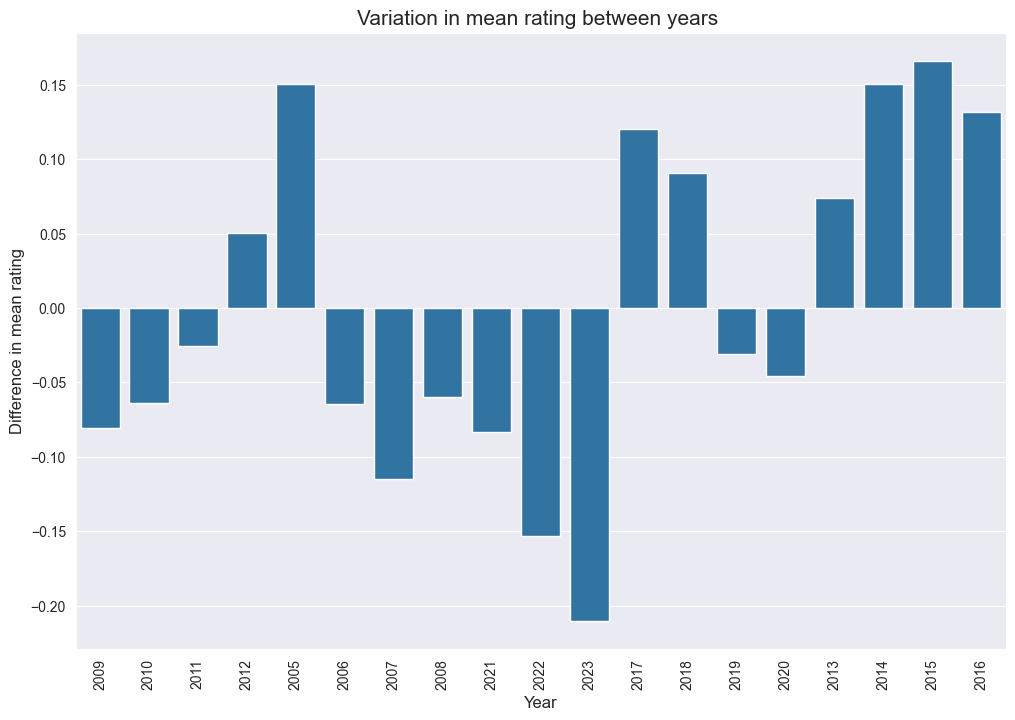

In [79]:
plt.figure(figsize=(12, 8))
g = sns.barplot(data=year_rating, x="year", y="difference_avg_rating")
plt.xticks(rotation=90)
g.set_title("Variation in mean rating between years ", fontsize=15)
g.set_xlabel("Year", fontsize=12)
g.set_ylabel("Difference in mean rating", fontsize=12)
plt.show()
plt.show()

## Most of the podcast reviews are from the covid-19 years, is this a coincidence or did more people listen to podcasts during lockdown ? 

Keep in mind that the number of reviews where on an increase before the covid-19 pandemic

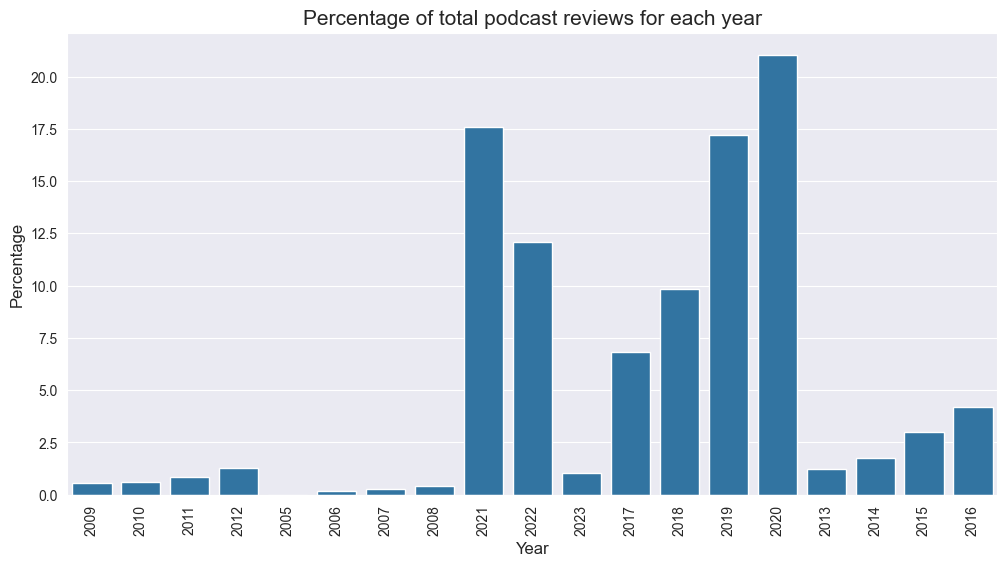

In [80]:
plt.figure(figsize=(12, 6))
g = sns.barplot(data=year_rating, x="year", y="reviews_percentage")
plt.xticks(rotation=90)
g.set_title("Percentage of total podcast reviews for each year", fontsize=15)
g.set_xlabel("Year", fontsize=12)
g.set_ylabel("Percentage", fontsize=12)
plt.show()
plt.show()

#### Creating statistics and confidence intervals for two years that are close in proximity (2022 and 2023)

We expect reviews to be lower rated in 2022 than in 2021

In [81]:
%%sql
ratings_2021_df <<
SELECT rating, year
FROM year_rating_df
WHERE year = 2021
ORDER BY rating ASC

Running query in 'duckdb'

In [82]:
%%sql
ratings_2022_df <<
SELECT rating, year
FROM year_rating_df
WHERE year = 2022
ORDER BY rating ASC

Running query in 'duckdb'

In [83]:
def confidence_interval(data, confidence=0.95):
    interval = st.norm.interval(confidence=confidence, loc=np.mean(data), scale=st.sem(data))
    return interval

In [84]:
ci_2022 = confidence_interval(ratings_2022_df["rating"], confidence=0.95)
ci_2021 = confidence_interval(ratings_2021_df["rating"], confidence=0.95)
print(f"The confidence interval for ratings in 2022 = {ci_2022}")
print(f"The confidence interval for ratings in 2021 = {ci_2021}")

The confidence interval for ratings in 2022 = (np.float64(4.489274016050548), np.float64(4.498735134333855))
The confidence interval for ratings in 2021 = (np.float64(4.560121298488119), np.float64(4.567492545263943))


Visualizing, by drawing a line between the lower and upper end of both confidence intervals, that the two confidence intervals doesn't overlap, and therefore indicating that there is a significant difference between the two means

<Axes: >

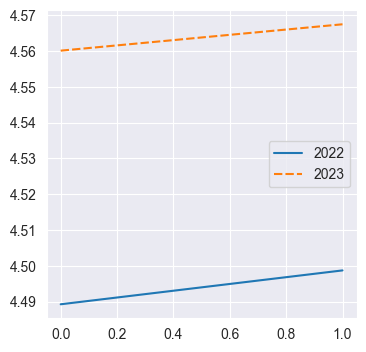

In [85]:
plt.figure(figsize=(4, 4))
df = pd.DataFrame({"2022": ci_2022, "2023": ci_2021})
sns.lineplot(df)

Null hypothesis: There is no significant difference between the mean rating of podcasts in 2021 and 2022
Alternate Hypothesis: Podcasts where higher rated in 2021 compared to 2022

### Podcasts where on average higher rated in 2021 compared to 2022

In [86]:
rating_2022 = ratings_2022_df["rating"].to_list()
rating_2021 = ratings_2021_df["rating"].to_list()

alpha = 0.05
t_stat, p_value = ztest(rating_2021, rating_2022, value=0, alternative="larger")
print(f"The test statistic = {t_stat} and the P-value = {p_value}")

if p_value < alpha:
    print(
        """
Reject the null hypothesis: Podcasts reviews in 2021 have on average a higher rating than in 2022"""
    )
else:
    print(
        """
Fail to Reject the null hypothesis: There is no significant difference between podcast review ratings in 2021 and 2022
          """
    )

The test statistic = 23.07487726098255 and the P-value = 4.139223877305146e-118

Reject the null hypothesis: Podcasts reviews in 2021 have on average a higher rating than in 2022


### There is a small difference in review rating from month to month 

In [87]:
%%sql
SELECT month, AVG(rating) AS average_rating, COUNT(title) AS reviews
FROM year_rating_df
WHERE month != ''
GROUP BY month
ORDER BY month ASC

Running query in 'duckdb'

,month,average_rating,reviews
0,01,4.619766,185241
1,02,4.655231,171886
2,03,4.633464,169713
3,04,4.644383,167731
4,05,4.641749,170372
5,06,4.611858,170850
6,07,4.625680,173397
7,08,4.625162,178429
8,09,4.624506,180498
9,10,4.625952,184404


In [88]:
%%sql
month_rating <<
WITH t1 AS(
SELECT month, AVG(rating) AS average_rating, COUNT(title) AS reviews
FROM year_rating_df
WHERE month != ''
GROUP BY month
ORDER BY month ASC)
SELECT t1.month, t1.average_rating, t1.average_rating - (SELECT AVG(t1.average_rating) FROM t1) AS difference_avg_rating, t1.reviews * 100 / (SELECT SUM(t1.reviews) FROM t1) AS reviews_percentage
FROM t1

Running query in 'duckdb'

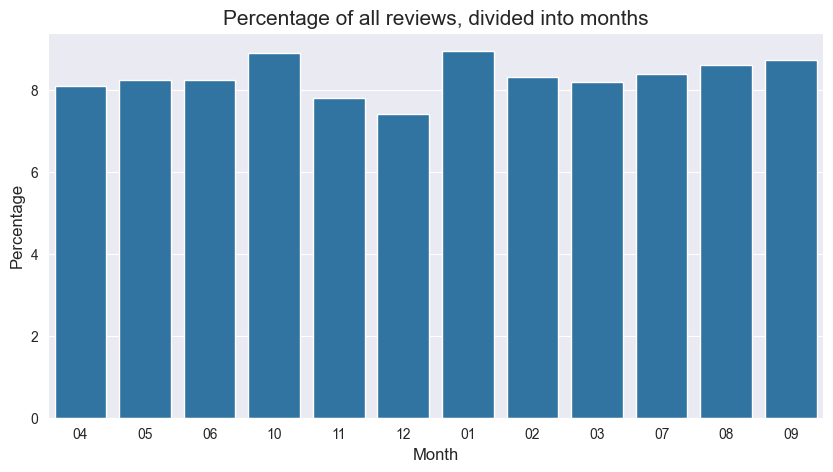

In [89]:
plt.figure(figsize=(10, 5))
g = sns.barplot(data=month_rating, x="month", y="reviews_percentage")
g.set_title("Percentage of all reviews, divided into months", fontsize=15)
g.set_xlabel("Month", fontsize=12)
g.set_ylabel("Percentage", fontsize=12)
plt.show();

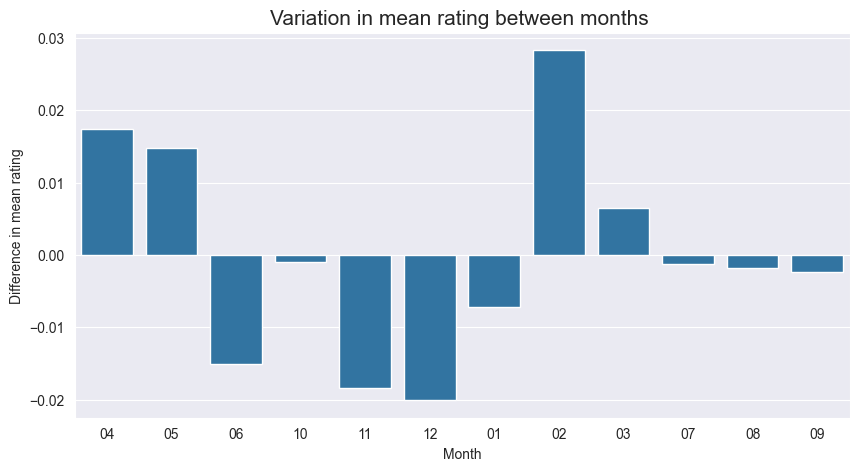

In [90]:
plt.figure(figsize=(10, 5))
g = sns.barplot(data=month_rating, x="month", y="difference_avg_rating")
g.set_title("Variation in mean rating between months ", fontsize=15)
g.set_xlabel("Month", fontsize=10)
g.set_ylabel("Difference in mean rating", fontsize=10)
plt.show();

## Summer months vs spring months, for all years and for the pandemic years (2019-2022) specifically 

### All years first

In [91]:
%%sql
spring_months <<
SELECT month, rating
FROM year_rating_df
WHERE month = 3 OR month = 4 OR month = 5
ORDER BY month

Running query in 'duckdb'

In [92]:
%%sql
summer_months <<
SELECT month, rating
FROM year_rating_df
WHERE month = 6 OR month = 7 OR month = 8
ORDER BY month

Running query in 'duckdb'

#### The confidence intervals do not overlap and this signifies that there is a significant difference between the two groups, ratings during summer vs during winter

In [93]:
ci_summer_months = confidence_interval(summer_months["rating"], confidence=0.95)
ci_spring_months = confidence_interval(spring_months["rating"], confidence=0.95)
print(f"The confidence interval for ratings in summer months = {ci_summer_months}")
print(f"The confidence interval for ratings in winter months = {ci_spring_months}")

The confidence interval for ratings in summer months = (np.float64(4.618128954218062), np.float64(4.623841214681982))
The confidence interval for ratings in winter months = (np.float64(4.637012491855731), np.float64(4.642687241906104))


<Axes: >

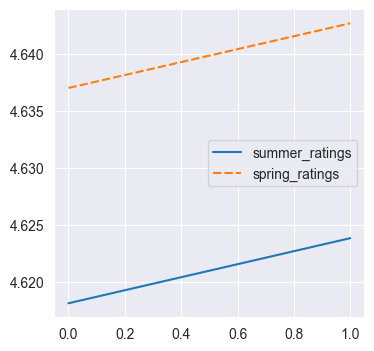

In [94]:
plt.figure(figsize=(4, 4))
winter_df = pd.DataFrame(
    {"summer_ratings": ci_summer_months, "spring_ratings": ci_spring_months}
)
sns.lineplot(winter_df)

In [95]:
spring_months_rating = spring_months["rating"].to_list()
summer_months_rating = summer_months["rating"].to_list()

alpha = 0.05
t_stat, p_value = ztest(
    spring_months_rating, summer_months_rating, value=0, alternative="larger"
)
print(f"The test statistic = {t_stat} and the P-value = {p_value}")

if p_value < alpha:
    print(
        """
Reject the null hypothesis: Podcast reviews during spring months are higher rated than summer months"""
    )
else:
    print(
        """
Fail to Reject the null hypothesis: There is not enough evidence to suggest a significant difference between podcast ratings during spring and summer
          """
    )

The test statistic = 9.181238109303772 and the P-value = 2.130814687825593e-20

Reject the null hypothesis: Podcast reviews during spring months are higher rated than summer months


### The pandemic years (2019-2021)

would 2019 -> 2022 be better ?

In [96]:
%%sql
month_rating_pandemic_years <<
WITH t1 AS(
SELECT month, AVG(rating) AS average_rating, COUNT(title) AS reviews
FROM year_rating_df
WHERE month != '' AND (year = 2019 OR year = 2020 OR year = 2021)
GROUP BY month
ORDER BY month ASC)
SELECT t1.month, t1.average_rating, t1.average_rating - (SELECT AVG(t1.average_rating) FROM t1) AS difference_avg_rating, t1.reviews * 100 / (SELECT SUM(t1.reviews) FROM t1) AS reviews_percentage
FROM t1

Running query in 'duckdb'

Some smaller differences in how reviews are divided into different months based on percentage, however the difference is small. 

Some similar trends in regards to review rating between all years and only the pandemic years 

Keep in mind that the pandemic years also is a majority of all reviews in this dataset, and it will influence the all years analysis, this might be redundant ? I'm choosing to keep this in as I've already done the work, however I realize as I am writing this that this is probably redundant. 

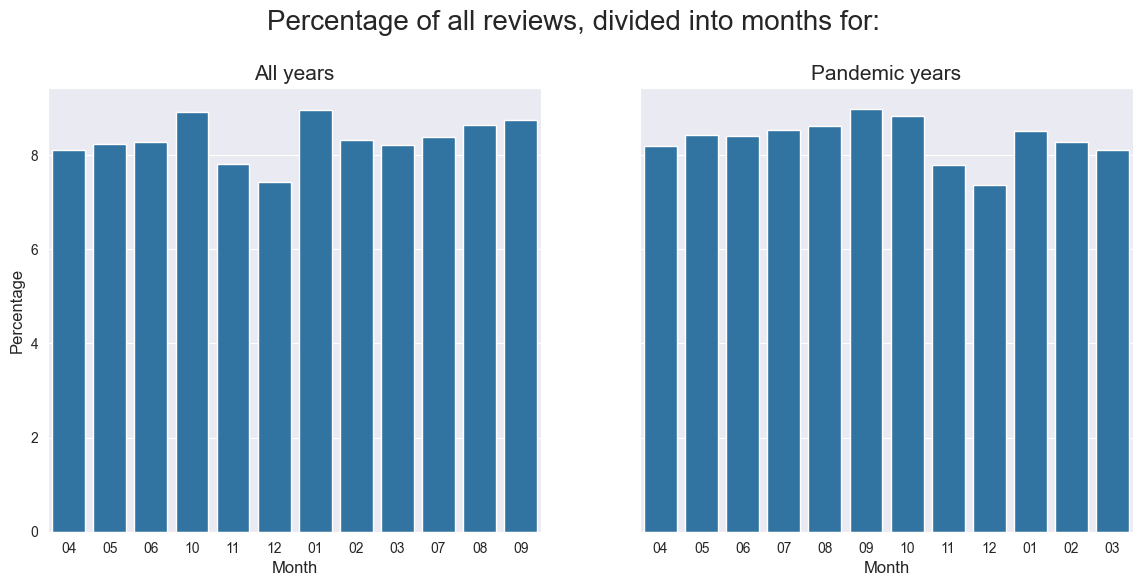

In [97]:
fig, axes = plt.subplots(1, 2, sharey="all")
fig.subplots_adjust(top=0.85)
sns.barplot(data=month_rating, x="month", y="reviews_percentage", ax=axes[0])
sns.barplot(data=month_rating_pandemic_years, x="month", y="reviews_percentage", ax=axes[1])

# sns.set_context("paper", font_scale=1.3)
fig.set_figheight(6)
fig.set_figwidth(14)

fig.suptitle("Percentage of all reviews, divided into months for:", fontsize=20)
axes[0].set_title("All years", fontsize=15)
axes[1].set_title("Pandemic years", fontsize=15)
axes[0].set_xlabel("Month", fontsize=12)
axes[1].set_xlabel("Month", fontsize=12)
axes[0].set_ylabel("Percentage", fontsize=12)
plt.show();

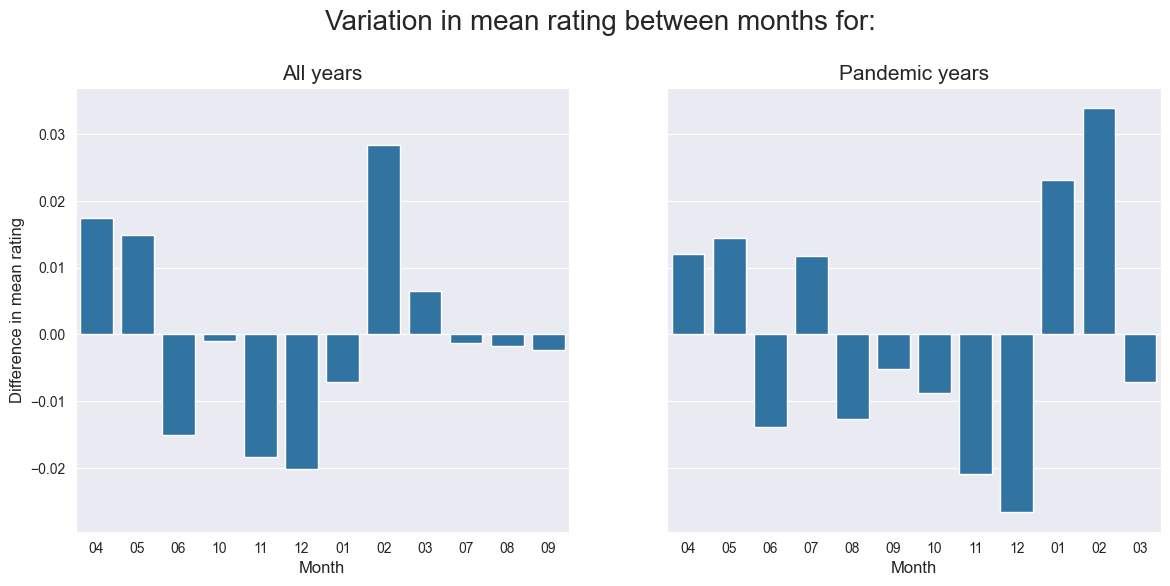

In [98]:
fig, axes = plt.subplots(1, 2, sharey="all")
fig.subplots_adjust(top=0.85)
sns.barplot(data=month_rating, x="month", y="difference_avg_rating", ax=axes[0])
sns.barplot(data=month_rating_pandemic_years, x="month", y="difference_avg_rating", ax=axes[1])
# sns.set_context("paper", font_scale=1.3)
fig.set_figheight(6)
fig.set_figwidth(14)

fig.suptitle("Variation in mean rating between months for:", fontsize=20)
axes[0].set_title("All years", fontsize=15)
axes[1].set_title("Pandemic years", fontsize=15)
axes[0].set_xlabel("Month", fontsize=12)
axes[1].set_xlabel("Month", fontsize=12)
axes[0].set_ylabel("Difference in mean rating", fontsize=12)
plt.show();

## Reviews for a specific podcast

Calling the review dataframe with adjustments so we only get one review per author in the dataframe

In [99]:
cur = con.cursor()
prompt = """
SELECT p.podcast_id, p.title AS podcast, r.author_id, r.title AS review_title, 
COUNT(r.title) AS one_review_per_author_per_podcast, rating, content,
strftime('%Y', created_at) AS year, strftime('%m', created_at) AS month
FROM reviews r
JOIN podcasts p
ON r.podcast_id = p.podcast_id
GROUP BY podcast, r.author_id, review_title
HAVING one_review_per_author_per_podcast = 1
ORDER BY one_review_per_author_per_podcast DESC
"""
cur.execute(prompt)
df = pd.DataFrame(cur.fetchall(), columns=[d[0] for d in cur.description])
cur.close()

Printing top 6 podcast to choose one to use in the analysis. Decided on diving deeper into reviews for True Crime Obsessed podcast.

In [100]:
%%sql
SELECT podcast, COUNT(review_title) AS count
FROM df
GROUP BY podcast
ORDER BY count DESC
LIMIT 6

Running query in 'duckdb'

,podcast,count
0,Crime Junkie,31052
1,My Favorite Murder with Karen Kilgariff and Ge...,9727
2,The Ben Shapiro Show,7464
3,True Crime Obsessed,6677
4,Wow in the World,5565
5,The Daily,5059


### True Crime Obsessed podcast

Making two dataframes, one based on crime (murder specifically) and one on politics (liberal, politic, or conservative) based on the content (whats in the review). Will compare the rating of these and see if the episode seemed more or less political vs about murder has any impact on review rating

Content of review have the word murder in it

In [101]:
%%sql
TCO_murder_df <<
SELECT *
FROM df
WHERE podcast = 'True Crime Obsessed' AND (LOWER(content) LIKE('%murder%'))
ORDER BY rating ASC


Running query in 'duckdb'

Content of review has something political in it

In [102]:
%%sql
TCO_politics_df <<
SELECT *
FROM df
WHERE podcast = 'True Crime Obsessed' AND (LOWER(content) LIKE('%liberal%') OR LOWER(content) LIKE('%politic%') OR LOWER(content) LIKE('%conservative%'))
ORDER BY rating ASC

Running query in 'duckdb'

Mean rating of reviews with either murder in the content or something political, there seems to be a difference in mean rating, will test this statistically 

In [103]:
%%sql
WITH t1 AS(
SELECT MEAN(rating) AS mean_murder_rating
FROM TCO_murder_df),
t2 AS(
SELECT MEAN(rating) AS mean_politics_rating
FROM TCO_politics_df)
SELECT t1.mean_murder_rating, t2.mean_politics_rating
FROM t1
CROSS JOIN t2

Running query in 'duckdb'

,mean_murder_rating,mean_politics_rating
0,3.373786,2.549296


In [104]:
%%sql
TCO_politics_metrics_df <<
SELECT (COUNT(rating)) AS population, MEAN(rating) AS mean, STDDEV(rating) AS standard_deviation
FROM TCO_politics_df

Running query in 'duckdb'

In [105]:
%%sql
TCO_murder_metrics_df <<
SELECT (COUNT(rating)) AS population, MEAN(rating) AS mean, STDDEV(rating) AS standard_deviation
FROM TCO_murder_df

Running query in 'duckdb'

The 95% confidence intervals suggest that there might be a statistically significant difference in rating between the podcasts that are too political and podcasts that are more murder oriented

In [106]:
ci_murder = confidence_interval(TCO_murder_df["rating"], confidence=0.95)
ci_politics = confidence_interval(TCO_politics_df["rating"], confidence=0.95)
print(f"The confidence interval for ratings in 'murder' episodes = {ci_murder}")
print(f"The confidence interval for ratings in 'political' episodes = {ci_politics}")

The confidence interval for ratings in 'murder' episodes = (np.float64(3.1196110026909816), np.float64(3.627961812842999))
The confidence interval for ratings in 'political' episodes = (np.float64(2.2810087363117453), np.float64(2.8175828129840297))


<Axes: >

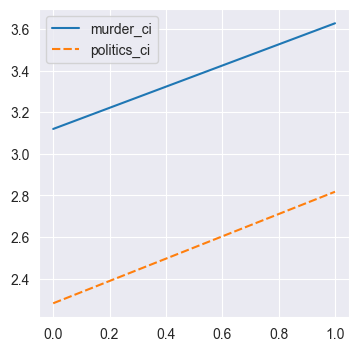

In [107]:
plt.figure(figsize=(4, 4))
SCO_df = pd.DataFrame({"murder_ci": ci_murder, "politics_ci": ci_politics})
sns.lineplot(SCO_df)

### We confirm this by doing a Z-test, we find that podcasts containing murder instead of politics are higher rated

I want to clarify that I do not know whether or not the podcast episode contain any political statements, I did however need something to practice statistics with. Maybe I could have said that reviews that contain comments about politics (liberal or conservative) are lower rated than reviews that contain the word murder in it, as this is what has actually been tested for. 

In [108]:
TCO_murder_rating = TCO_murder_df["rating"].to_list()
TCO_politics_rating = TCO_politics_df["rating"].to_list()

alpha = 0.05
t_stat, p_value = ztest(TCO_murder_rating, TCO_politics_rating, value=0, alternative="larger")
print(f"The test statistic = {t_stat} and the P-value = {p_value}")

if p_value < alpha:
    print(
        """
Reject the null hypothesis: Podcast episodes containing murder instead of politics is higher rated"""
    )
else:
    print(
        """
Fail to Reject the null hypothesis: There is not enough evidence to suggest a significant difference ratings in political and murder episodes
          """
    )

The test statistic = 4.267979784777993 and the P-value = 9.862559887271141e-06

Reject the null hypothesis: Podcast episodes containing murder instead of politics is higher rated


## Unsure why this one doesnt work, I'm leaving it in if you have any comments, if I figure it out I will remove this code before the review

However, doing a two sample Z-test with another method gives another result:
There is no significant difference between the mean rating of podcasts that are more murder oriented compared to those that are more politically oriented. 

Alternate hypothesis:
There is a significant difference between the mean rating of podcasts that are more murder oriented compared to those that are more politically oriented. 

In [109]:
population1 = float(TCO_murder_metrics_df["population"][0])
mean1 = float(TCO_murder_metrics_df["mean"][0])
std1 = float(TCO_murder_metrics_df["standard_deviation"][0])

population2 = float(TCO_politics_metrics_df["population"][0])
mean2 = float(TCO_politics_metrics_df["mean"][0])
std2 = float(TCO_politics_metrics_df["standard_deviation"][0])

D = 0

alpha = 0.05

z_score = (mean1 - mean2) - D / np.sqrt((std1**2 / population1) + (std2**2 / population2))
print("Z-Score:", np.abs(z_score))

z_critical = st.norm.ppf(1 - alpha / 2)
print("Critical Z-score:", z_critical)

if np.abs(z_score) > z_critical:
    print(
        """Reject the null hypothesis.
There is a significant difference between ratings in political and murder episodes"""
    )

else:
    print(
        """Fail to reject the null hypothesis.
There is not enough evidence to suggest a significant difference ratings in political and murder episodes
          """
    )

Z-Score: 0.8244906331191029
Critical Z-score: 1.959963984540054
Fail to reject the null hypothesis.
There is not enough evidence to suggest a significant difference ratings in political and murder episodes
          


Ignore this, its only to write files to CSV for Looker studio


In [110]:
%%sql
subcategory_df <<
SELECT r.podcast, c.*
FROM combined_removed_dupe_df c
JOIN one_review_df r
ON c.podcast_id = r.podcast_id

Running query in 'duckdb'

In [111]:
sub_categories_podcast_reviews_df.to_csv("sub_categories_podcast_reviews.csv")

In [112]:
subcategory_df.to_csv("subcategory.csv")